In [61]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import folium
import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [116]:
df_raw = pd.read_csv('zillow_data.csv')
df_raw.head()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
# Import zipcode database to pair with data
df_Zipcode = pd.read_csv('zip_code_database.csv')

In [6]:
# Rename RegionName to Zipcode to merge data from zip code import
df_raw.rename(columns={'RegionName': 'Zipcode'}, inplace = True)

In [7]:
# Drop other columns and keep Zipcode (for merge), Lat/Long, and estimated Population
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


In [8]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [9]:
#Dividing zipcodes into region 
df_East = df[df_raw.Zipcode < 50000]
df_Central = df[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]
df_West = df[(df.Zipcode >= 80000)]
#West coast** 
df_West.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3799700,3793900,3778700,3770800,3763100,3779800,3813500,37.79,-122.42,39680
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,594700,598500,601300,602800,606100,612400,616200,33.91,-118.34,85010
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,405400,408600,410900,413700,417900,424300,430100,38.01,-121.91,89590
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1903900,1907500,1922100,1952400,1974500,1975900,1966900,34.11,-118.36,35600
56,94748,85032,Phoenix,AZ,Phoenix,Maricopa,57,95400.0,95800.0,96200.0,...,259500,260700,261900,263100,264100,265400,266400,33.62,-112.00,57380


In [10]:
# California Data frame
cali_df_uf = df_West[(df_West['State'] == 'CA')]
cali_df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 9 to 14712
Columns: 275 entries, RegionID to irs_estimated_population
dtypes: float64(221), int64(50), object(4)
memory usage: 2.6+ MB


In [11]:
print(cali_df_uf.shape)
cali_df_uf.head()

(1224, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3799700,3793900,3778700,3770800,3763100,3779800,3813500,37.79,-122.42,39680
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,594700,598500,601300,602800,606100,612400,616200,33.91,-118.34,85010
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,405400,408600,410900,413700,417900,424300,430100,38.01,-121.91,89590
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1903900,1907500,1922100,1952400,1974500,1975900,1966900,34.11,-118.36,35600
64,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,222400.0,...,1000000,1009900,1021000,1032400,1042000,1053000,1059700,37.77,-122.27,56900


## Narrowing down results 
### 1) Population Density

In [12]:
cali_df_uf['irs_estimated_population'].mean()

27356.438725490196

In [13]:
cali_df_uf['irs_estimated_population'].median()

25565.0

In [14]:
cali_dff = cali_df_uf[(cali_df_uf.irs_estimated_population >= 28000)]

### 2) Price Percentile 

In [15]:
cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(cali_dff['yr_avg'].describe(),'\n')
#Calculate the 75% cutoff value (1 decile above).
q_75 = cali_dff['yr_avg'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = cali_dff['yr_avg'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
cali_dff1 = cali_dff[(cali_dff['yr_avg']<q_75) & (cali_dff['yr_avg']>q_25)]
print(f'Amount of zipcodes: {len(cali_dff1)}')

count    5.440000e+02
mean     5.007335e+05
std      3.624352e+05
min      9.349306e+04
25%      2.906666e+05
50%      4.093647e+05
75%      5.722068e+05
max      2.839833e+06
Name: yr_avg, dtype: float64 

Average Value 75% cutoff value: 572206.75
Average Value 25% cutoff value: 290666.58
Amount of zipcodes: 272


<ipython-input-15-e1790964b6dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)


In [16]:
# After filtering the percentiles
print(cali_dff1.shape)

(272, 276)


In [17]:
cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2013-01'])/ cali_dff1['2013-01'],4)

<ipython-input-17-48b8358f04ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2013-01'])/ cali_dff1['2013-01'],4)


In [18]:
cali_dff1.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,601300,602800,606100,612400,616200,33.91,-118.34,85010,457793.797500,0.6776
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,410900,413700,417900,424300,430100,38.01,-121.91,89590,316700.508333,1.2530
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,404200,409700,414300,418500,421100,33.95,-118.29,78060,309681.305000,0.9003
90,96239,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,91,128300.0,128100.0,127800.0,...,447700,451700,455000,457600,459100,33.86,-118.18,83830,341920.473333,0.7067
93,98325,95630,Folsom,CA,Sacramento,Sacramento,94,190000.0,189300.0,188500.0,...,537200,542400,544600,544100,542900,38.67,-121.14,69990,408717.294167,0.4385


In [19]:
# cali_dff1.sort_values(by=['ROI_5'], ascending = False)

In [20]:
cali_df3 = cali_dff1.nlargest(5, 'ROI_5')
cali_df3.sort_values(by=['ROI_5'], ascending = False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,535800,546900,555000,562000,566700,37.77,-122.21,45290,406675.463333,1.9257
1853,97850,94804,Richmond,CA,San Francisco,Contra Costa,1854,171300.0,170300.0,169400.0,...,448000,452400,459200,471800,483100,37.92,-122.34,38610,342635.465000,1.5534
1681,97808,94606,Oakland,CA,San Francisco,Alameda,1682,120400.0,120300.0,120300.0,...,663100,676500,683700,691700,696800,37.78,-122.24,30770,496223.795000,1.5394
1379,97807,94605,Oakland,CA,San Francisco,Alameda,1380,143600.0,143300.0,143100.0,...,644000,653300,662900,672000,675000,37.75,-122.13,38090,485650.468333,1.3759
1191,95999,90018,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1192,133200.0,132900.0,132400.0,...,640300,643100,646400,652700,658000,34.02,-118.31,40590,482883.809167,1.3243


In [21]:
# #Calculate historical return on investment
# cali_dff1['ROI']= (cali_dff1['2018-04']/cali_dff1['1996-04'])-1
# #Calculate standard deviation of monthly values
# cali_dff1['std']=cali_dff1.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
# #Calculate historical mean value
# cali_dff1['mean']=cali_dff1.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
# #Calculate coefficient of variance
# cali_dff1['CV']=cali_dff1['std']/cali_dff1['mean']
# #Show calculated values
# cali_dff1[['RegionName','std','mean','ROI','CV']].head()

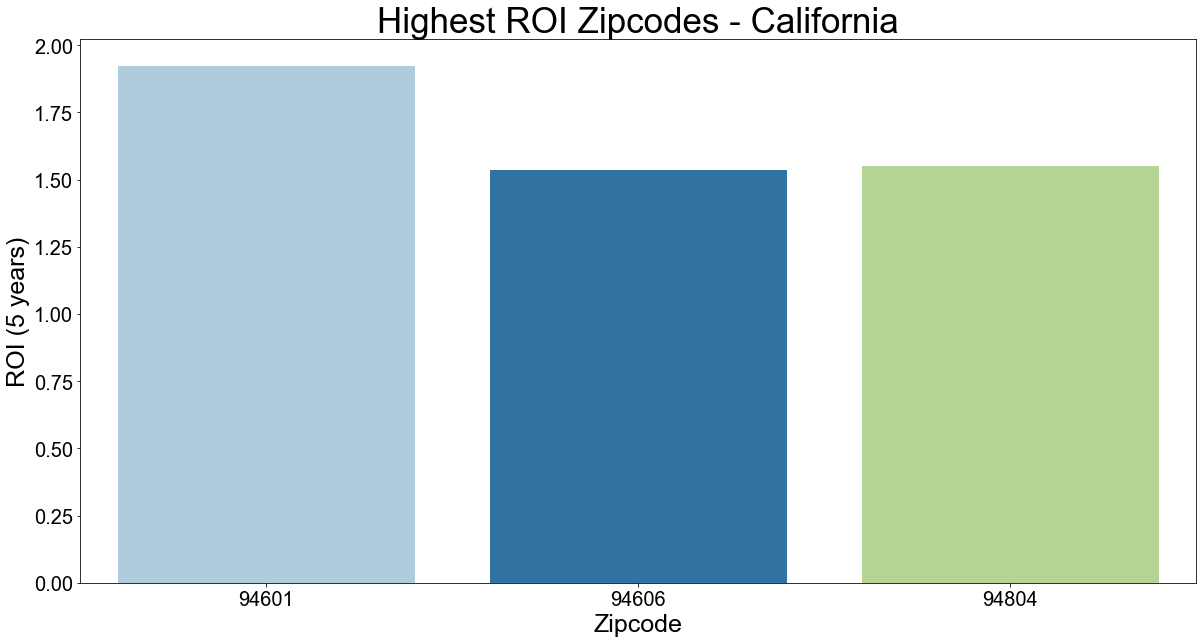

In [22]:

fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("Paired"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = cali_df3[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - California", fontsize = 35)

plt.show()

In [23]:
cali_map = folium.Map([36.99, -119.78], zoom_start = 6.3, width = '75%')
for lat, lon in zip(cali_df3['latitude'][:3], cali_df3['longitude'][:3]):
    folium.CircleMarker([lat, lon], radius = 10, color = 'darkred').add_to(cali_map)
cali_map

# Time Series for top 3 zip codes

In [24]:
df94601 = cali_df3[cali_df3['Zipcode']== 94601]
df94601.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,535800,546900,555000,562000,566700,37.77,-122.21,45290,406675.463333,1.9257


In [25]:
df94606 = cali_df3[cali_df3['Zipcode']== 94606]

In [26]:
df94804 = cali_df3[cali_df3['Zipcode']== 94804]

In [27]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')

In [28]:
get_datetimes(df94601)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [121]:
get_datetimes(df94606)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [122]:
get_datetimes(df94804)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [29]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [31]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population','yr_avg', 'ROI_5']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [123]:
melted_94601 = melt_data(df94601)
melted_94601
melted_94604 = melt_data(df94606)
melted_94804 = melt_data(df94804)

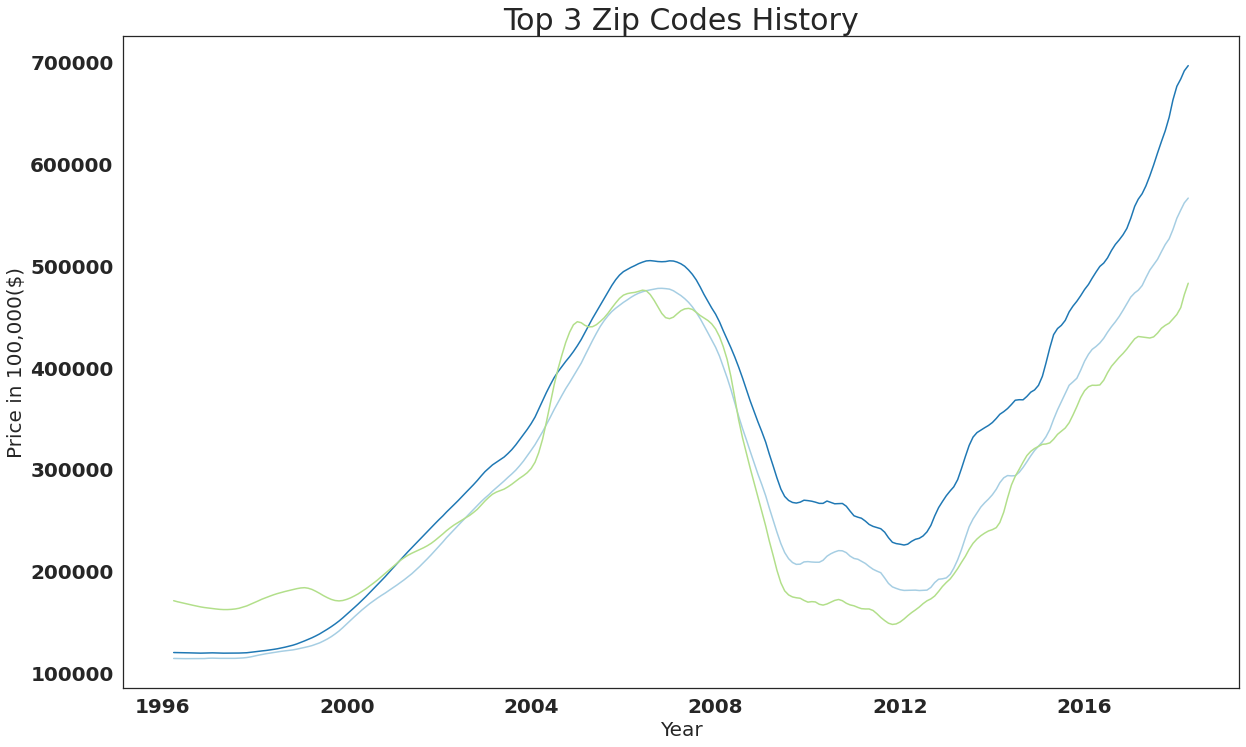

In [131]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_94601)
ax.plot(melted_94604)
ax.plot(melted_94804)

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Top 3 Zip Codes History',fontsize=30);

In [34]:
# train_set = melted_94601[:'2015-12']
# val_set = melted_94601['2016-01':]

In [36]:
melted_cali = melt_data(cali_dff1)

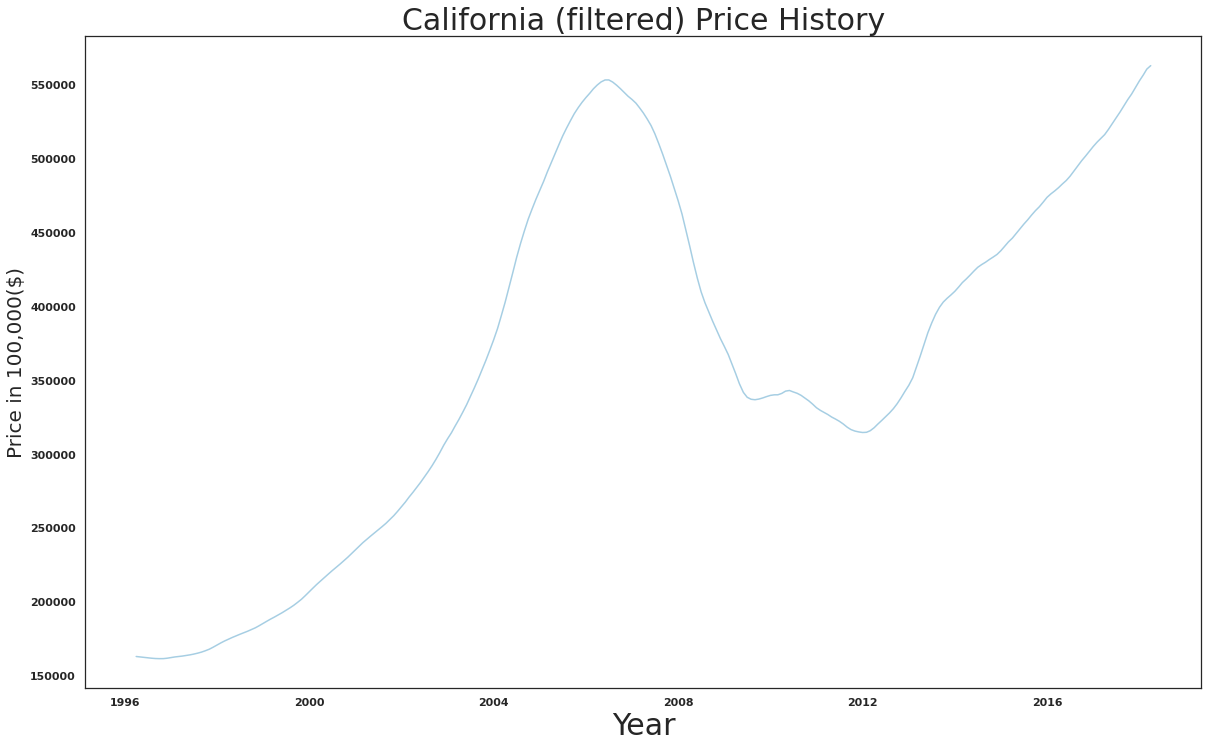

In [38]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_cali)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('California (filtered) Price History',fontsize=30);

In [139]:
train_set = melted_cali[:'2015-12']
test_set = melted_cali['2016-01':]

In [140]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_set):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] [42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80] [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  8

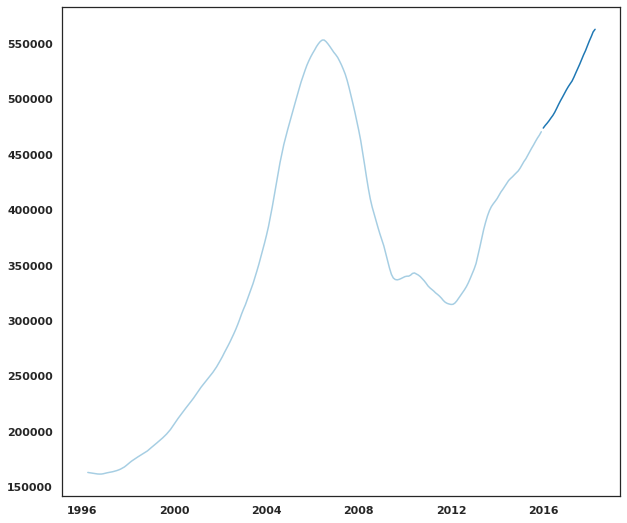

In [141]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(train_set, label = 'train')
ax.plot(test_set, label = 'test')

In [172]:
naive1 = train_set.shift(1)
naive2 = train_set.shift(2)
naive3 = train_set.shift(3)

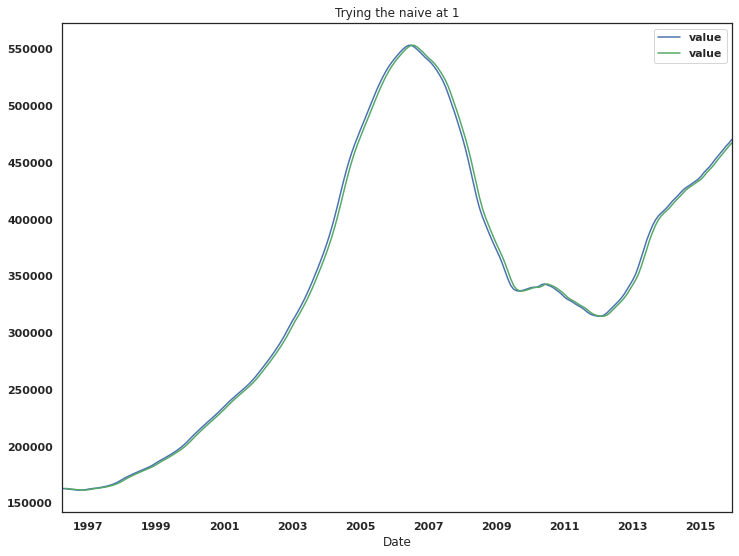

In [173]:
fig, ax = plt.subplots(figsize=(12,9))

train_set[0:400].plot(ax=ax, c = 'b', label = 'orig')
naive1[0:400].plot(ax=ax, c = 'g', label = 'naive')
ax.set_title("Trying the naive at 1")
ax.legend()

In [175]:
print(np.sqrt(mean_squared_error(train_set[3:], naive3.dropna())))
print(np.sqrt(mean_squared_error(train_set[2:], naive2.dropna())))
print(np.sqrt(mean_squared_error(train_set[1:], naive1.dropna())))

12749.231342320087
8509.011618629585
4256.308588209223


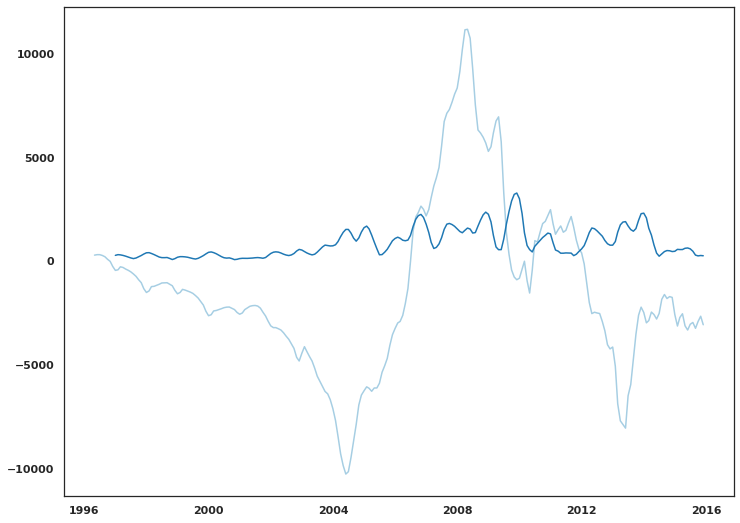

In [190]:
# Plotting Residuals
fig, ax = plt.subplots(figsize=(12,9))
residuals = naive1[1:] - train_set[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(window = 9).std())

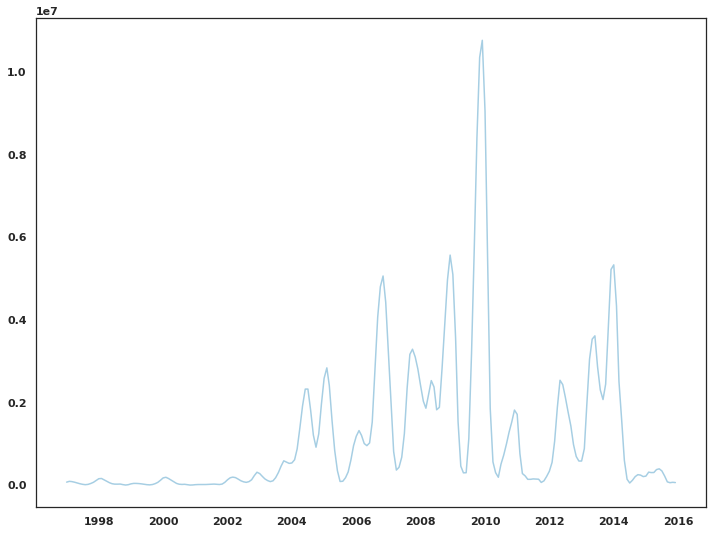

In [192]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(residuals.index, residuals.rolling(9).var())

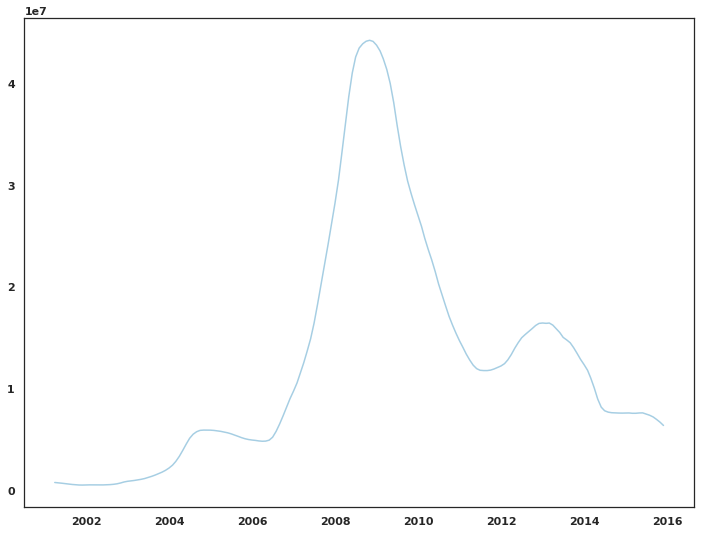

In [189]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(residuals.index, residuals.rolling(60).var())

Text(0.5, 1.0, 'Difference of training set')

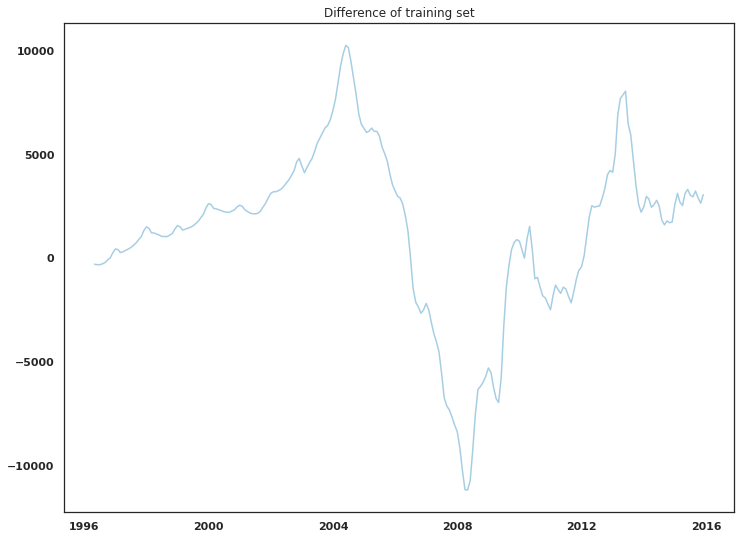

In [160]:
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(train_set.diff())
ax.set_title('Difference of training set')

# Modeling

In [91]:
ar1 = ARIMA(train_set, order = (1, 1, 1)).fit()
ar1_pred = ar1.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [54]:
# Best AIC (lowest)
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2239.481
Date:                Thu, 27 Oct 2022   AIC                           4484.962
Time:                        01:27:36   BIC                           4495.354
Sample:                    04-01-1996   HQIC                          4489.151
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9278      0.016     58.734      0.000       0.897       0.959
ma.L1         -0.8642      0.020    -42.919      0.000      -0.904      -0.825
sigma2      9.735e+06   9.55e-11   1.02e+17      0.000    9.73e+06    9.73e+06
===================================================================================
Ljung-Box (L1) (Q):                 213.61   Jarque-Bera (JB):                87.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.09e+33. Standard errors may be unstable.
"""

In [55]:
ar2 = ARIMA(train_set, order = (0, 1, 1)).fit()
ar2.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1996-04-01         0.000000
1996-05-01    182450.994422
1996-06-01    160385.914230
1996-07-01    162834.156433
1996-08-01    162177.388559
                  ...      
2015-08-01    456145.359270
2015-09-01    459100.962341
2015-10-01    462381.247247
2015-11-01    465254.571549
2015-12-01    467889.926320
Freq: MS, Name: predicted_mean, Length: 237, dtype: float64

In [56]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2292.611
Date:                Thu, 27 Oct 2022   AIC                           4589.221
Time:                        01:29:08   BIC                           4596.149
Sample:                    04-01-1996   HQIC                          4592.014
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1268      0.006     20.544      0.000       0.115       0.139
sigma2      1.793e+07   1.77e-11   1.02e+18      0.000    1.79e+07    1.79e+07
===================================================================================
Ljung-Box (L1) (Q):                 177.23   Jarque-Bera (JB):               180.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -1.22
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [57]:
ar3 = ARIMA(train_set, order = (0, 1, 0)).fit()
ar3.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1996-04-01         0.000000
1996-05-01    163151.291513
1996-06-01    162866.420664
1996-07-01    162558.671587
1996-08-01    162251.291513
                  ...      
2015-08-01    455806.250000
2015-09-01    458768.382353
2015-10-01    462012.132353
2015-11-01    464931.250000
2015-12-01    467593.382353
Freq: MS, Name: predicted_mean, Length: 237, dtype: float64

In [58]:
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2306.924
Date:                Thu, 27 Oct 2022   AIC                           4615.847
Time:                        01:29:48   BIC                           4619.311
Sample:                    04-01-1996   HQIC                          4617.244
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.804e+07   1.67e+06     10.800      0.000    1.48e+07    2.13e+07
===================================================================================
Ljung-Box (L1) (Q):                 234.50   Jarque-Bera (JB):                29.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
yhat_ar1 = ar1.predict(typ='levels')
np.sqrt(mean_squared_error(train_set, yhat_ar1))

11068.815408768703

No handles with labels found to put in legend.


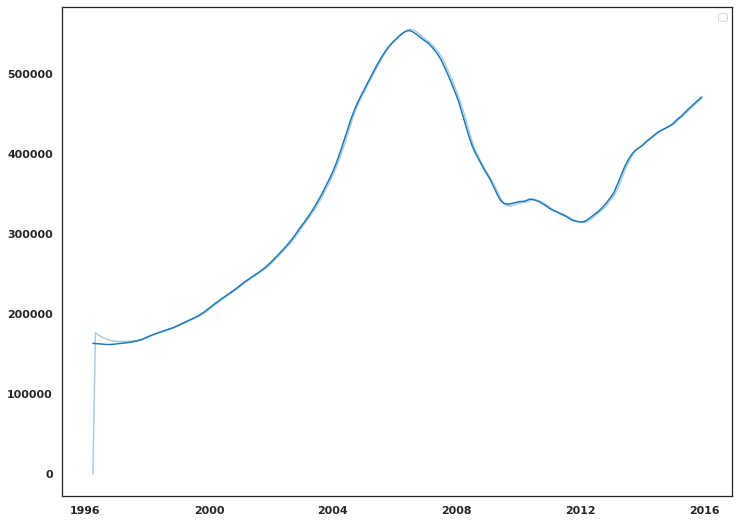

In [132]:
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(ar1_pred)
ax.plot(train_set)
plt.legend(loc= 'best')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


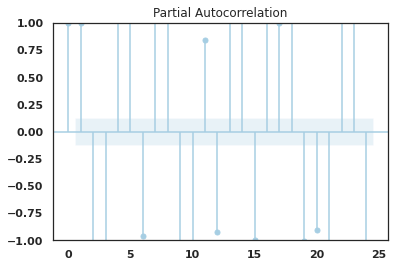

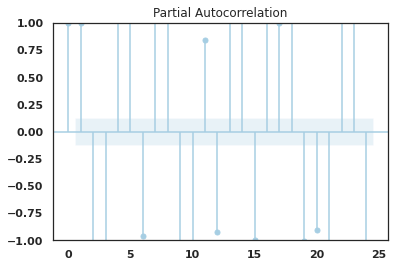

In [60]:
plot_pacf(train_set.diff().dropna())

<AxesSubplot:xlabel='Date'>

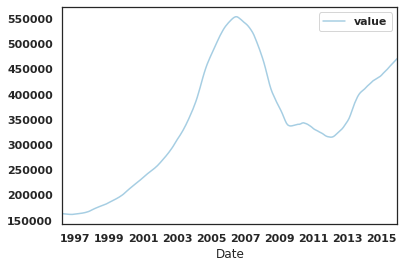

In [76]:
train_set.plot()

<AxesSubplot:xlabel='Date'>

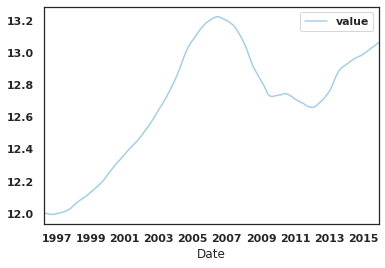

In [75]:
np.log(train_set).plot()

<AxesSubplot:xlabel='Date'>

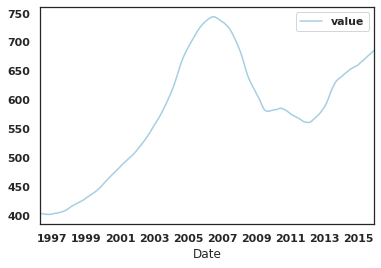

In [78]:
np.sqrt(train_set).plot()

In [64]:
decomposition = seasonal_decompose(np.log(train_set))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

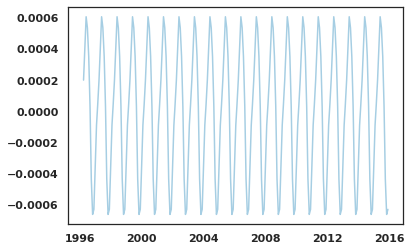

In [74]:
plt.plot(seasonal)

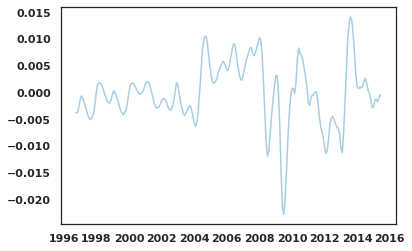

In [73]:
plt.plot(residual)

In [87]:
train_log_dec = residual
train_log_dec = train_log_dec.dropna()

In [88]:
dftest = adfuller(train_log_dec)

In [89]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -3.610370
p-value                          0.005566
#Lags Used                       8.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


In [90]:
data_transform = np.sqrt(train_set)
diff = data_transform.diff().dropna()

In [84]:
pd.DataFrame(np.hstack((data_transform[1:].values.reshape(-1, 1),diff.values.reshape(-1,1))))

,0,1
0,403.567120,-0.352787
1,403.185654,-0.381466
2,402.804284,-0.381370
3,402.469774,-0.334511
4,402.214809,-0.254965
...,...,...
231,677.324429,2.190183
232,679.714743,2.390314
233,681.858673,2.143930
234,683.808001,1.949328


In [85]:
adfuller(diff)

(-2.409960927065006,
 0.1389447251057066,
 10,
 225,
 {'1%': -3.4597521044060353,
  '5%': -2.874472927517147,
  '10%': -2.5736628197530864},
 103.13909741639748)

In [101]:
import itertools

# SARIMA

In [ ]:
# p = q = range(0,2)
# pdq = list(itertools.product(p, [1], q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]

# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i,s))

In [135]:
p = q = range(0,2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i,s))

SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [136]:
for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try: 
            mod=SARIMAX(train_set, 
                        order = param,
                        seasonal_order = param_seasonal,
                        enforce_stationary=False,
                        enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print ('blank')
            continue

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (0, 1, 0) x (0, 1, 0, 52) - AIC:3813.8336699105084


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 0) x (0, 1, 1, 52) - AIC:7028.455433450896


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (0, 1, 0) x (1, 1, 0, 52) - AIC:3813.4831029983307


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 0) x (1, 1, 1, 52) - AIC:7056.763973114471


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (0, 1, 1) x (0, 1, 0, 52) - AIC:3933.478898285925


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 1) x (0, 1, 1, 52) - AIC:5639.3599780392315


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (0, 1, 1) x (1, 1, 0, 52) - AIC:3917.3935573930157


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (0, 1, 1) x (1, 1, 1, 52) - AIC:8.0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (1, 1, 0) x (0, 1, 0, 52) - AIC:3753.3988043471636


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (0, 1, 1, 52) - AIC:6553.3579593462855


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (1, 1, 0) x (1, 1, 0, 52) - AIC:3730.3142370793103


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (1, 1, 1, 52) - AIC:6335.2912850533885


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (1, 1, 1) x (0, 1, 0, 52) - AIC:3595.1303310444137


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (0, 1, 1, 52) - AIC:6084.982345522738


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (1, 1, 1) x (1, 1, 0, 52) - AIC:3719.750405625454


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA (1, 1, 1) x (1, 1, 1, 52) - AIC:10.0


In [138]:
sari_mod_test1 = SARIMAX(train_set, 
                 order = (0, 1, 1,),
                 seasonal_order = (0, 1, 1, 52),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
sari_mod_test2 = SARIMAX(train, 
                 order = (1, 1, 1,),
                 seasonal_order = (0, 1, 1, 52),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

In [ ]:
sari_mod_test3 = SARMIAX(train, 
                 order = (1, 1, 1,),
                 seasonal_order = (0, 1, 1, 60),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

## California (West Coast)

In [ ]:
cali_df.isnull().sum()

In [ ]:
cali_df.isna().sum().sum()

In [ ]:
cali_df.iloc[:,7:].isnull().sum()

In [ ]:
# cali_df = cali_df.dropna(inplace=True, subset=list(cali_df.columns[216:]))
# cali_df.interpolate(inplace = True)

In [ ]:
cali_df.Zipcode = cali_df.Zipcode.astype('string')

In [ ]:
# cali_df.plot(figsize = (12,6))

In [ ]:
## 5 year ROI
cali_df['ROI_5'] = round((cali_df['2018-04'] - cali_df['2013-01'])/ cali_df['2013-01'],4)
## 3 year ROI, this metric should be the metric used
cali_df['ROI_3'] = round((cali_df['2018-04'] - cali_df['2015-01'])/ cali_df['2015-01'],4)

In [ ]:
cali_df['ROI_5']

In [ ]:
cali_df['ROI_3']

In [ ]:
cali_df.info

In [ ]:
#RWM
avg = 0
std = 10 
n_pts = 1000
date_vals = pd.date_range(starts = '04/01/1996')

In [ ]:
# def melt_data(df):
#     """
#     Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
#     Returns a long-form datetime dataframe 
#     with the datetime column names as the index and the values as the 'values' column.
    
#     If more than one row is passes in the wide-form dataset, the values column
#     will be the mean of the values from the datetime columns in all of the rows.
#     """
    
#     melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})